# Exercise 6.1

## point (a)

In mathematics, the **Kuramoto–Sivashinsky equation** (or KS equation or flame equation) is a fourth-order nonlinear partial differential equation. It is named after Yoshiki Kuramoto and Gregory Sivashinsky, who derived the equation in the late 1970s to model the diffusive–thermal instabilities in a laminar flame front and it is known for its **chaotic behavior**.

The 1-D version of the KS equation can be written as:
$$ u_t + u_{xx} + u_{xxxx} + \frac{1}{2}u_x^2 = 0 $$

In [1]:
# Import the necessary libraries.
import numpy as np
import scipy.io
import os
import time

# Import plotting libraries and tools.
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [2]:
# Import data.

# get the right path to the data.
data_path = os.path.join( os.path.abspath("") , "DATA\kuramoto_sivishinky.mat" )
# load the data.
data = scipy.io.loadmat( data_path )
uu = data["uu"].T
x = data["x"].squeeze()
tt = data["tt"].squeeze()

# save the important dimensions.
t_len = len(tt)
x_len = len(x)
print("NUMBER OF TIME-STEPS:", t_len)
print("NUMBER OF SPACE-POINTS:", x_len)

NUMBER OF TIME-STEPS: 251
NUMBER OF SPACE-POINTS: 1024


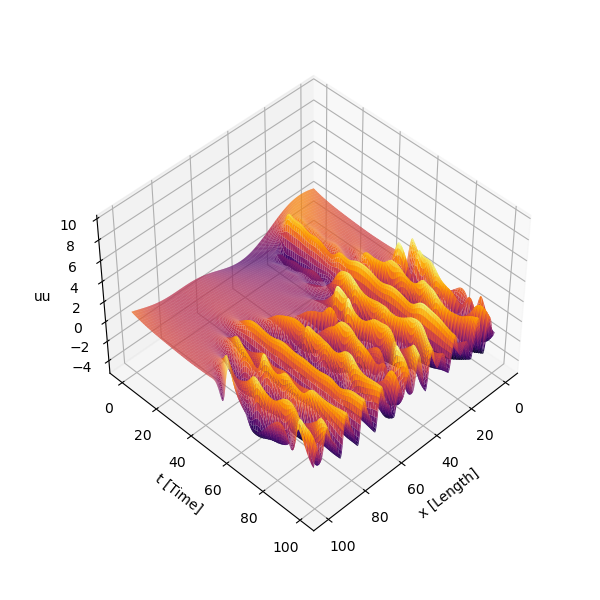

In [3]:
# Plot the data.

fig = plt.figure( figsize = ( 6 , 6 ) )
ax = fig.add_subplot( 1 , 1 , 1 , projection = '3d' )
X , T = np.meshgrid( x , tt )
surf = ax.plot_surface( X , T , uu , cmap = 'inferno' , rstride = 3, cstride = 3, antialiased = True )
ax.set_xlabel('x [Length]')
ax.set_ylabel('t [Time]')
ax.set_zlabel('uu')
ax.set_zlim( -5 , 10 )
ax.view_init( 45 , 45 )
plt.show()

## Dataset

The data can be interpreted as a temporal-sequence of $251$ vectors (labelled throught $t_0,...,t_{250}$), each composed of $1024$ space points (labelled throught $x_0,...,x_{1024}$). This mean that, if $uu$ is a matrix of dimension $(251 \times 1024)$, given the column $uu^{(j)}$, we want to predict column $uu^{(j+\Delta j)}$. \
SETP 1: first and former, we must prepare the dataset:
- The input dataset, $IN$, will correspond to a matrix of dimension $((251 - \Delta j) \times 1024)$, which contains the coulmns from $uu^{(0)}$ to $uu^{(250 - \Delta j)}$. 
- The labels (or output), $OUT$, will be composed of a matrix with same dimension, but whose columns span from $uu^{(\Delta j)}$ to $uu^{(250)}$. 

We tried to implement two different experiments:
- CASE 1: The network takes as input $uu^{(j)},...,uu^{(j+\Delta j -1)}$ and gives back as its output $uu^{(j+\Delta j)}$. In this case the data pair is composed of a tuple and a vector ([$uu^{(j)},...,uu^{(j+\Delta j-1)}$],$uu^{(j+\Delta j)}$).
- CASE 2: The network takes as input $uu^{(j)}$ and gives back as its output $uu^{(j+\Delta j)}$. Each pair of columns ($uu^{(j)}$,$uu^{(j+\Delta j)}$) is a data-pair.


## CASE 1
- **STEP 1:** Create the data pairs.

In [4]:
# Choose a DELTA T (from 0 to 251)
DT = 10

# divide the dataset between input (past) and output (future).
past = uu[ : ( t_len - DT ) , : ] 
future = uu[ DT : (t_len) , : ] 

# define IN and OUT coherently with their description.
IN = np.zeros(( t_len - DT , DT , x_len ))
OUT = future

for i in range( 0 , t_len - DT , 1 ):
    IN[i] = uu[ i : i + DT , : ]

- **STEP 2:** sample one data pair randomly from the dataset and plot it.

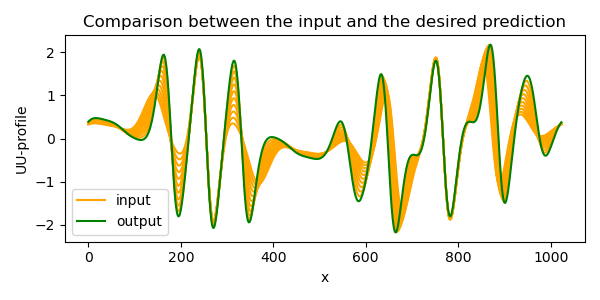

In [5]:
from numpy import random
np.random.seed(42)
k = random.randint( 0 , high = ( t_len - 1 - DT ) , dtype = int )

x_ = IN[k]
x_prime = OUT[k]
comparison = OUT[ k - DT ]

fig.clear()
plt.close()

fig , ax = plt.subplots( 1 , figsize = ( 6 , 3 ) )
ax.plot( x_[0] , label = "input", color = "orange")
for i in range( 1 , DT, 1 ):
    ax.plot(x_[i], color = "orange")
ax.plot( x_prime , label = "output" , color = "green")
ax.set_xlabel("x")
ax.set_ylabel("UU-profile")
ax.set_title('Comparison between the input and the desired prediction')

fig.tight_layout()
plt.legend()
plt.show()

- **STEP 3:** Divide the dataset in *training*, *validation* and *test set*.

In [6]:
# Divide the dataset between trining, validation and test sets.
dataset_len = len(IN)
train_len = int(dataset_len  * 0.8)
val_len = int(dataset_len  * 0.1)
test_len = int(dataset_len  * 0.1)

# Random shuffle to select the pairs non-sequentially.
idx = np.random.choice( IN.shape[0] , dataset_len  , replace = False )
idx_train = idx[ 0 : train_len ]
idx_val = idx[ train_len : ( train_len + val_len ) ]
idx_test = idx[ ( train_len + val_len ): ]

# Get the dataset done.
TRAIN_IN = np.take( IN , idx_train , axis = 0)
TRAIN_OUT = np.take( OUT , idx_train , axis = 0)
VAL_IN = np.take( IN , idx_val , axis = 0)
VAL_OUT = np.take( OUT , idx_val , axis = 0)
TEST_IN = np.take( IN , idx_test , axis = 0)
TEST_OUT = np.take( OUT , idx_test , axis = 0)

## Model

For CASE 1 the model is a **simple RNN** implemented in Keras; it takes as input the $\Delta j$ time-steps before $j+\Delta j$ and gives as output $uu^{(j)}$.
- **STEP 1:** Define the model.

In [7]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Define the number of timesteps, inputs, outputs, and hidden units
num_timesteps = DT
num_inputs = x_len
num_outputs = x_len
hidden_size = 50

# Create a sequential model
model = Sequential()
model.add( SimpleRNN( hidden_size , activation='tanh', input_shape=( num_timesteps , num_inputs ) ) )
model.add( Dense( num_outputs , activation='linear' ) )

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                53750     
                                                                 
 dense (Dense)               (None, 1024)              52224     
                                                                 
Total params: 105,974
Trainable params: 105,974
Non-trainable params: 0
_________________________________________________________________


- **STEP 2:** Define the *optimization algorithm*, the *Loss function*, the *learning rate* and compile the model.

In [8]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

OPTIMIZER = Adam(learning_rate = 0.01)
LOSS = MeanSquaredError()

model.compile( optimizer = OPTIMIZER , loss = LOSS )

- **STEP 3:** Train the model.

In [9]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping( monitor='val_loss' , patience = 5 , min_delta = 1e-10)

H = model.fit( TRAIN_IN , TRAIN_OUT , 
               validation_data = ( VAL_IN , VAL_OUT ) ,
               validation_freq = 1 ,
               epochs = 600 ,
               shuffle = True ,
               callbacks=[callback] ,
               verbose = 0)  

- **STEP 4:** Plot the training history.

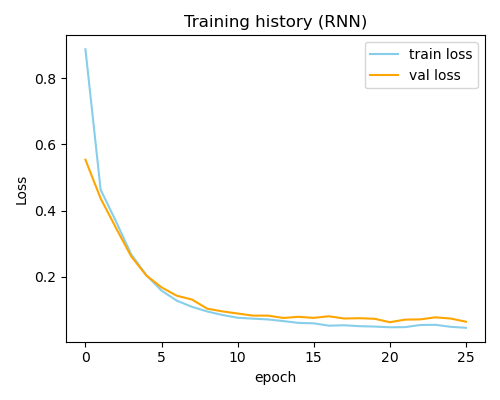

In [10]:
fig.clear()
plt.close()

fig , ax = plt.subplots( 1 , figsize = ( 5 , 4 ) )
ax.plot( H.history["loss"] , label = "train loss", color = "skyblue" )
ax.plot( H.history["val_loss"] , label = "val loss", color = "orange" )
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.set_title('Training history (RNN)')

fig.tight_layout()
plt.legend()
plt.show()

- **STEP 5:** Use the model to make predictions and evaluate them trought the MSE.

In [11]:
TEST_PRED = model.predict(TEST_IN)
TEST_MSE = LOSS(TEST_PRED,TEST_OUT)
TOT_PRED = model.predict(IN)
TOT_MSE = LOSS(TOT_PRED,OUT)

print("\n--->The MSE on the test set is: {:.3f}".format(TEST_MSE.numpy()))
print("--->The MSE on the entire dataset is: {:.3f}".format(TOT_MSE.numpy())+"\n")

8/8 [==============================] - 0s 8ms/step

--->The MSE on the test set is: 0.053
--->The MSE on the entire dataset is: 0.047



- **STEP 6:** compare the real $uu$ profiles with the predicted $uu$ profiles in a movie. 

In [12]:
from IPython.display import Video
Video('./Output/RNN_performance.mp4', embed = True )

- **STEP 7:** Plot the prediction of the entire dataset.

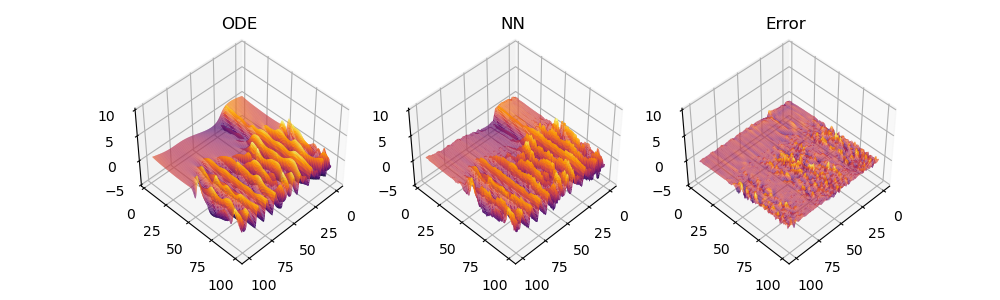

In [12]:
fig.clear()
plt.close()

err = TOT_PRED - uu[DT:]

# Plot the comparison ammong the NN and ODE trajectories.
X , T = np.meshgrid( x , tt )
fig, axes = plt.subplots(1, 3, figsize=( 10 , 3 ) , subplot_kw = { "projection" : "3d" } )
for zz, label, ax in zip( [ uu[DT:] , TOT_PRED, err], ['ODE', 'NN', 'Error'], axes):
    surf = ax.plot_surface( X[DT:] , T[DT:] , zz , cmap = 'inferno' , rstride = 3 , cstride = 3 , antialiased = True )
    ax.set_zlim( -5 , 10 )
    ax.set_title( label )
    ax.view_init( 45 , 45 )
plt.show()

# CASE 2
- **STEP 1:** Create the data pairs.

In [13]:
# Choose a DELTA T (from 0 to 251)
DT_ = 30

# Create the input and output pairs.
IN_ = uu[ :( t_len - DT_ ) , : ] 
OUT_ = uu[ DT_ : (t_len) , : ] 

- **SETP 2:** Plot the data pairs.

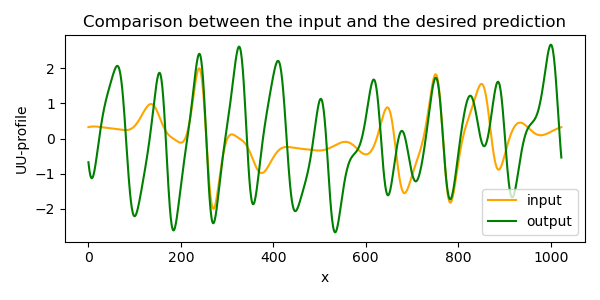

In [14]:
x_ = IN_[100]
x_prime = OUT_[100]
comparison = OUT_[ 100 - DT_ ]

fig.clear()
plt.close()

fig , ax = plt.subplots( 1 , figsize = ( 6 , 3 ) )
ax.plot( x_ , label = "input", color = "orange" )
ax.plot( x_prime , label = "output" , color = "green" )
ax.set_xlabel("x")
ax.set_ylabel("UU-profile")
ax.set_title('Comparison between the input and the desired prediction')

fig.tight_layout()
plt.legend()
plt.show()

- **STEP 3:** Divide the data in training, validation and test set.

In [15]:
# Divide the dataset between trining, validation and test sets.
dataset_len_ = len(IN_)
train_len_ = int(dataset_len_  * 0.8)
val_len_ = int(dataset_len_  * 0.1)
test_len_ = int(dataset_len_  * 0.1)

# Random shuffle to select the pairs non-sequentially.
idx_ = np.random.choice( IN_.shape[0] , dataset_len_  , replace = False )
idx_train_ = idx_[ 0 : train_len_ ]
idx_val_ = idx_[ train_len_ : ( train_len_ + val_len_ ) ]
idx_test_ = idx_[ ( train_len_ + val_len_ ): ]

# Get the dataset done.
TRAIN_IN_ = np.take( IN_ , idx_train_ , axis = 0)
TRAIN_OUT_ = np.take( OUT_ , idx_train_ , axis = 0)
VAL_IN_ = np.take( IN_ , idx_val_ , axis = 0)
VAL_OUT_ = np.take( OUT_ , idx_val_ , axis = 0)
TEST_IN_ = np.take( IN_ , idx_test_ , axis = 0)
TEST_OUT_ = np.take( OUT_ , idx_test_ , axis = 0)

## Model

For CASE 2 the model is a FFNN implemented in Keras; it takes as input $uu^{(j)}$ and gives as output $uu^{(j+\Delta j)}$.

- **STEP 1:** Define the model.

In [16]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM

num_inputs_ = x_len
num_outputs_ = x_len

# Create a sequential model
model_ = Sequential()

model_.add( Dense( 512 , activation = 'tanh', input_shape = ( num_inputs_ , ) ) )
model_.add( Dense( num_outputs_ , activation = 'linear' ) )

# Print the summary of the model
model_.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
Total params: 1,050,112
Trainable params: 1,050,112
Non-trainable params: 0
_________________________________________________________________


- **STEP 2:** Define the optimization algorithms, the loss, the learning rate and compile the model.

In [18]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

OPTIMIZER = Adam(learning_rate = 0.0005)
LOSS = MeanSquaredError()

model_.compile( optimizer = OPTIMIZER , loss = LOSS )

- **STEP 3:** train the model.

In [ ]:
from keras.callbacks import EarlyStopping

callback_ = EarlyStopping( monitor = 'val_loss' , patience = 5, min_delta = 1e-10 )

H_ = model_.fit( TRAIN_IN_ , TRAIN_OUT_ , 
               validation_data = ( VAL_IN_ , VAL_OUT_ ) ,
               validation_freq = 1 ,
               epochs = 1000 ,
               shuffle = True ,
               callbacks=[callback_] ,
               verbose = 0) 

NameError: name 'model_' is not defined

- **STEP 4:** plot the training history.

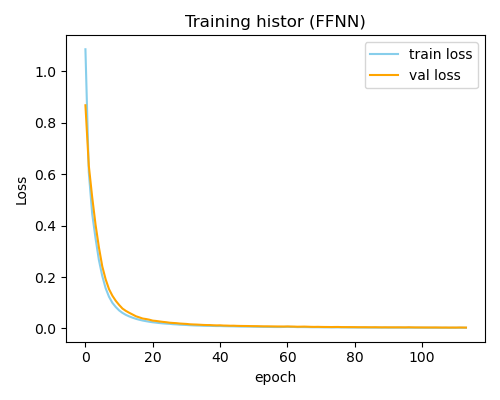

In [20]:
fig.clear()
plt.close()

fig , ax = plt.subplots( 1 , figsize = ( 5 , 4 ) )
ax.plot( H_.history["loss"] , label = "train loss", color = "skyblue" )
ax.plot( H_.history["val_loss"] , label = "val loss", color = "orange" )
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.set_title('Training histor (FFNN)')

fig.tight_layout()
plt.legend()
plt.show()

- **STEP 5:** use the model to make predictions and the MSE to evaluate them.

In [21]:
TEST_PRED_ = model_.predict(TEST_IN_)
TEST_MSE_ = LOSS(TEST_PRED_,TEST_OUT_)
TOT_PRED_ = model_.predict(IN_)
TOT_MSE_ = LOSS(TOT_PRED_,OUT_)

print("\n--->The MSE on the test set is: {:.3f}".format(TEST_MSE_.numpy()))
print("--->The MSE on the entire dataset is: {:.3f}".format(TOT_MSE_.numpy())+"\n")
print("Now the overfitting a bit looks better! but the accuracy in the overall "+
      "predictions looks worse.\n")

7/7 [==============================] - 0s 2ms/step

--->The MSE on the test set is: 0.004
--->The MSE on the entire dataset is: 0.003

Now the overfitting a bit looks better! but the accuracy in the overall predictions looks worse.



- **STEP 6:** compare the real $uu$ profiles with the predicted $uu$ profiles in a movie. 

In [22]:
from IPython.display import Video
Video('./Output/FFNN_performance.mp4', embed = True )

- **STEP 7:** plot the predictions of the entire dataset.

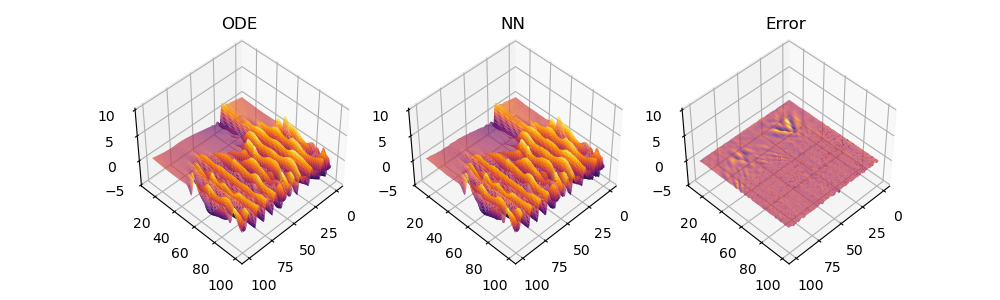

In [23]:
fig.clear()
plt.close()

err = TOT_PRED_ - uu[DT_:]

# Plot the comparison ammong the NN and ODE trajectories.
X , T = np.meshgrid( x , tt )
fig, axes = plt.subplots(1, 3, figsize=( 10 , 3 ) , subplot_kw = { "projection" : "3d" } )
for zz, label, ax in zip( [ uu[DT_:] , TOT_PRED_ , err], ['ODE', 'NN', 'Error'], axes):
    surf = ax.plot_surface( X[DT_:] , T[DT_:] , zz , cmap = 'inferno' , rstride = 3 , cstride = 3 , antialiased = True )
    ax.set_zlim( -5 , 10 )
    ax.set_title( label )
    ax.view_init( 45 , 45 )
plt.show()